Convert Time Column

In [7]:
import pandas as pd

df = pd.read_csv("2023.csv")

# Convert time column
df['Measurement Time'] = pd.to_datetime(
    df['Measurement Time'],
    format='%d-%m-%Y %H:%M'
)

df.head()


,Measurement Time,Production (W),To Battery (W),To Grid (W),To Home (W),Consumption (W),From Battery (W),From Grid (W),From Solar (W)
0,2023-01-01 00:00:00,NaN,NaN,NaN,NaN,2108.3892,0.0,2108.3892,0.0
1,2023-01-01 00:15:00,NaN,NaN,NaN,NaN,2888.8093,0.0,2888.8093,0.0
2,2023-01-01 00:30:00,NaN,NaN,NaN,NaN,2760.1907,0.0,2760.1907,0.0
3,2023-01-01 00:45:00,NaN,NaN,NaN,NaN,2816.5450,0.0,2816.5450,0.0
4,2023-01-01 01:00:00,NaN,NaN,NaN,NaN,2932.5800,0.0,2932.5800,0.0


Create Time based Features

In [8]:
df['hour'] = df['Measurement Time'].dt.hour
df['day'] = df['Measurement Time'].dt.day
df['month'] = df['Measurement Time'].dt.month
df['weekday'] = df['Measurement Time'].dt.weekday


Add Day/Night Features

In [9]:
df['day_night'] = df['hour'].apply(
    lambda x: 1 if 6 <= x < 18 else 0
)


| Value | Meaning |
| ----- | ------- |
| 1     | Day     |
| 0     | Night   |


Kerala Tariff Feature

In [10]:
def kerala_tariff(hour):
    if 6 <= hour < 18:
        return 6.5  # Day tariff
    else:
        return 4.5  # Night tariff

df['tariff'] = df['hour'].apply(kerala_tariff)


Check missing values

In [11]:
df.isna().sum()


,0
Measurement Time,0
Production (W),16066
To Battery (W),16067
To Grid (W),16067
To Home (W),16067
Consumption (W),154
From Battery (W),154
From Grid (W),154
From Solar (W),154
hour,0


Handling missing value

In [12]:
df.sort_values('Measurement Time', inplace=True)

df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)


/tmp/ipython-input-2593968741.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/tmp/ipython-input-2593968741.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


In [13]:
df.isna().sum()


,0
Measurement Time,0
Production (W),0
To Battery (W),0
To Grid (W),0
To Home (W),0
Consumption (W),0
From Battery (W),0
From Grid (W),0
From Solar (W),0
hour,0


Prosumer Role Label

In [14]:
def prosumer_role(row):
    prod = row['Production (W)']
    cons = row['Consumption (W)']

    if prod >= cons and prod > 0:
        return 'Producer'      # surplus → can sell
    elif prod > 0 and prod < cons:
        return 'Prosumer'      # produces + consumes
    else:
        return 'Consumer'      # only consumes


In [15]:
df['role'] = df.apply(prosumer_role, axis=1)


In [16]:
print(df.columns)


Index(['Measurement Time', 'Production (W)', 'To Battery (W)', 'To Grid (W)',
       'To Home (W)', 'Consumption (W)', 'From Battery (W)', 'From Grid (W)',
       'From Solar (W)', 'hour', 'day', 'month', 'weekday', 'day_night',
       'tariff', 'role'],
      dtype='object')


Save cleaned Dataset

In [17]:
df.to_csv("kerala_energy_preprocessed2.csv", index=False)

In [18]:
from google.colab import files
files.download("kerala_energy_preprocessed2.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#consumption prediction

input

hour
day
month
weekday
day_night
tariff


Output

Consumption (W)


***select features and target***

In [19]:
features = ['hour', 'day', 'month', 'weekday', 'day_night', 'tariff']
target = 'Consumption (W)'

X = df[features]
y = df[target]

print(X.head())
print(y.head())

   hour  day  month  weekday  day_night  tariff
0     0    1      1        6          0     4.5
1     0    1      1        6          0     4.5
2     0    1      1        6          0     4.5
3     0    1      1        6          0     4.5
4     1    1      1        6          0     4.5
0    2108.3892
1    2888.8093
2    2760.1907
3    2816.5450
4    2932.5800
Name: Consumption (W), dtype: float64


In [20]:
df.isna().sum()


,0
Measurement Time,0
Production (W),0
To Battery (W),0
To Grid (W),0
To Home (W),0
Consumption (W),0
From Battery (W),0
From Grid (W),0
From Solar (W),0
hour,0


***Train-test split***

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (28032, 6)
Test size: (7008, 6)


#Linear Regression

***Train***

In [22]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)


LinearRegression()

***predict***

In [23]:
y_pred_lr = lr.predict(X_test)


#linear regression evaluation

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression MAE:", mae_lr)
print("Linear Regression RMSE:", rmse_lr)
print("Linear Regression R2:", r2_lr)


Linear Regression MAE: 794.4043325375275
Linear Regression RMSE: 1157.388999155116
Linear Regression R2: 0.025821855280982242


***visualization***

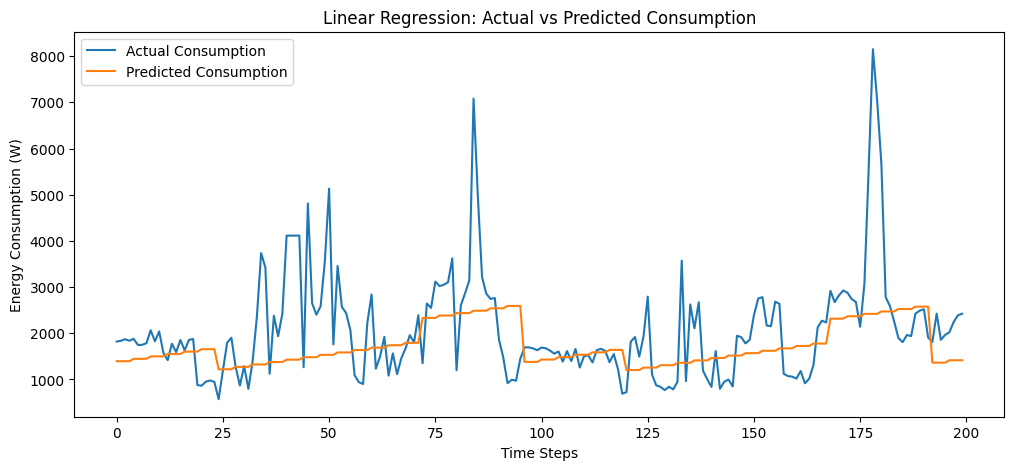

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_test.values[:200], label='Actual Consumption')
plt.plot(y_pred_lr[:200], label='Predicted Consumption')
plt.title('Linear Regression: Actual vs Predicted Consumption')
plt.xlabel('Time Steps')
plt.ylabel('Energy Consumption (W)')
plt.legend()
plt.show()


***Scatter Plot***

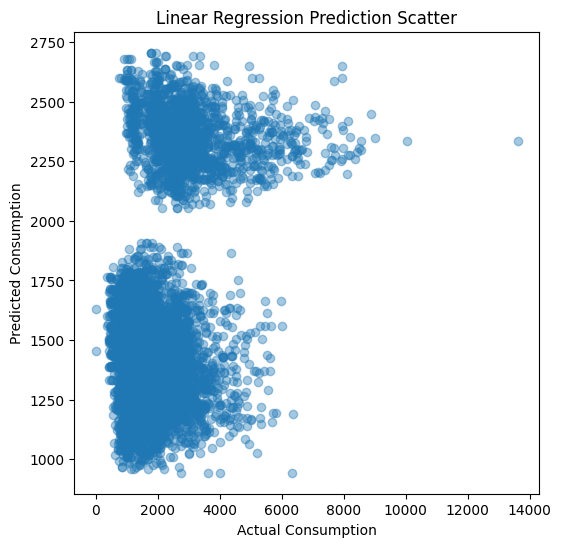

In [26]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_lr, alpha=0.4)
plt.xlabel('Actual Consumption')
plt.ylabel('Predicted Consumption')
plt.title('Linear Regression Prediction Scatter')
plt.show()


***Error Distribution***

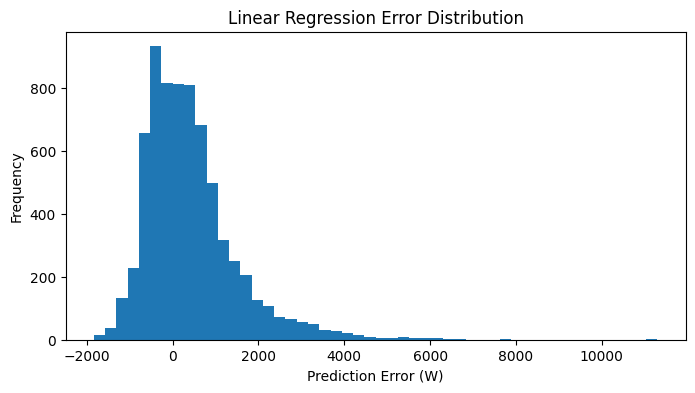

In [27]:
errors = y_test - y_pred_lr

plt.figure(figsize=(8,4))
plt.hist(errors, bins=50)
plt.title('Linear Regression Error Distribution')
plt.xlabel('Prediction Error (W)')
plt.ylabel('Frequency')
plt.show()



#Random Forest

***Train***

In [28]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)


RandomForestRegressor(max_depth=15, n_estimators=200, n_jobs=-1,
                      random_state=42)

***Predict***

In [29]:
y_pred_rf = rf.predict(X_test)


#Random Forest Evaluation

In [30]:
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("RF MAE:", mae_rf)
print("RF RMSE:", rmse_rf)
print("RF R2:", r2_rf)


RF MAE: 786.9913198558797
RF RMSE: 1097.9822827235505
RF R2: 0.1232609580920282


***Visualization(Actual vsPredicted)***

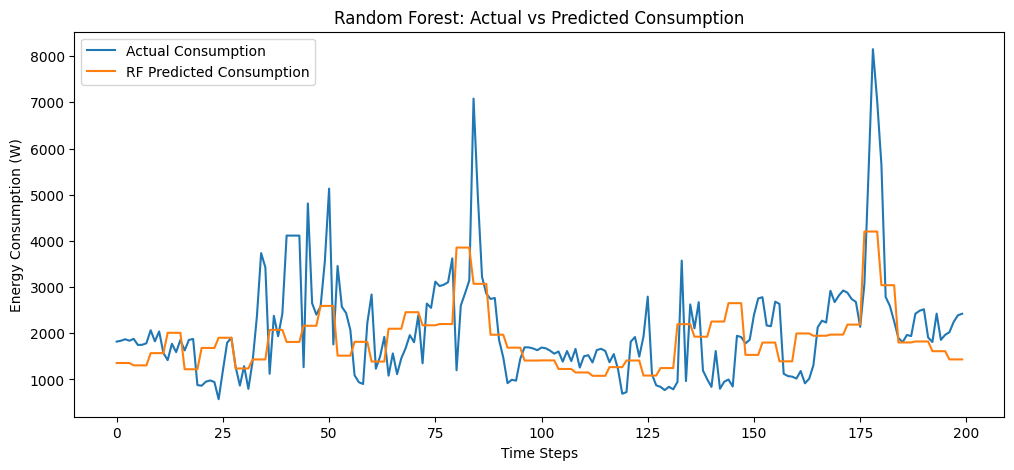

In [31]:
plt.figure(figsize=(12,5))
plt.plot(y_test.values[:200], label='Actual Consumption')
plt.plot(y_pred_rf[:200], label='RF Predicted Consumption')
plt.title('Random Forest: Actual vs Predicted Consumption')
plt.xlabel('Time Steps')
plt.ylabel('Energy Consumption (W)')
plt.legend()
plt.show()


***Scatter plot( model accuracy comparison )***

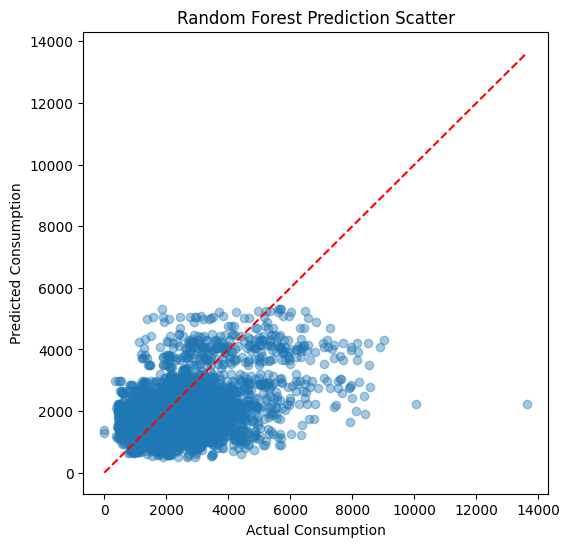

In [32]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.4)
plt.xlabel('Actual Consumption')
plt.ylabel('Predicted Consumption')
plt.title('Random Forest Prediction Scatter')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')
plt.show()


***Error distribution***

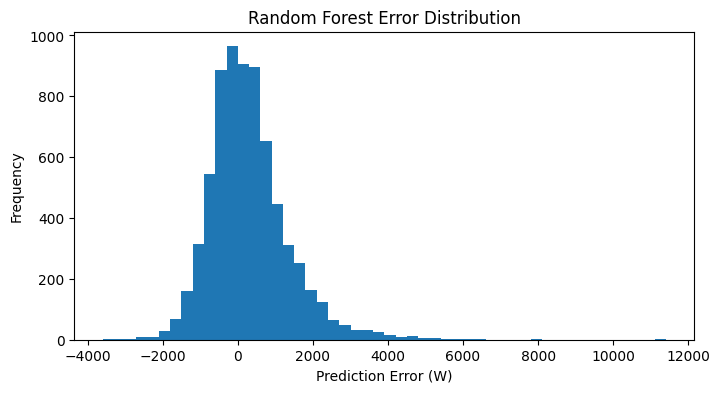

In [33]:
errors_rf = y_test - y_pred_rf

plt.figure(figsize=(8,4))
plt.hist(errors_rf, bins=50)
plt.title('Random Forest Error Distribution')
plt.xlabel('Prediction Error (W)')
plt.ylabel('Frequency')
plt.show()


***Feature importance***

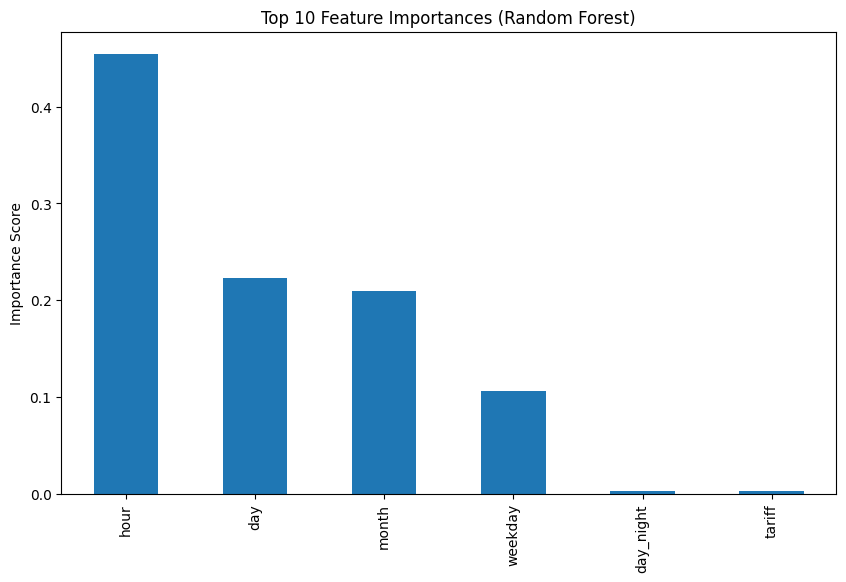

In [34]:
import pandas as pd

feature_importance = pd.Series(
    rf.feature_importances_, index=X.columns
).sort_values(ascending=False)

plt.figure(figsize=(10,6))
feature_importance.head(10).plot(kind='bar')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.ylabel('Importance Score')
plt.show()


tolerance based accuracy

In [36]:
def tolerance_accuracy(y_true, y_pred, tolerance=0.1):
    error = abs(y_true - y_pred) / y_true
    return (error <= tolerance).mean() * 100


In [37]:
acc_lr = tolerance_accuracy(y_test, y_pred_lr)
acc_rf = tolerance_accuracy(y_test, y_pred_rf)

print("LR Accuracy (±10%):", acc_lr)
print("RF Accuracy (±10%):", acc_rf)


LR Accuracy (±10%): 13.65582191780822
RF Accuracy (±10%): 14.46917808219178


save linear regression

In [39]:
import joblib

joblib.dump(lr, 'linear_regression_consumption.pkl')


['linear_regression_consumption.pkl']

save random forest

In [40]:
joblib.dump(rf, 'random_forest_consumption.pkl')


['random_forest_consumption.pkl']

#LightGBM

In [74]:
!pip install lightgbm


In [76]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import train_test_split

# Redefine features and target for tabular models (as used for Linear Regression and Random Forest)
features_lgbm = ['hour', 'day', 'month', 'weekday', 'day_night', 'tariff']
target_lgbm = 'Consumption (W)'

X_lgbm = df[features_lgbm]
y_lgbm = df[target_lgbm]

# Resplit the data for LGBM to get 2D arrays
X_train_lgbm, X_test_lgbm, y_train_lgbm, y_test_lgbm = train_test_split(
    X_lgbm, y_lgbm, test_size=0.2, shuffle=False
)

lgb_model = lgb.LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=10,
    random_state=42
)

lgb_model.fit(X_train_lgbm, y_train_lgbm)

y_pred_lgb = lgb_model.predict(X_test_lgbm)

lgb_mae = mean_absolute_error(y_test_lgbm, y_pred_lgb)
lgb_rmse = np.sqrt(mean_squared_error(y_test_lgbm, y_pred_lgb))
lgb_r2 = r2_score(y_test_lgbm, y_pred_lgb)

print("LightGBM MAE:", lgb_mae)
print("LightGBM RMSE:", lgb_rmse)
print("LightGBM R2:", lgb_r2)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 79
[LightGBM] [Info] Number of data points in the train set: 28032, number of used features: 6
[LightGBM] [Info] Start training from score 2166.843345
LightGBM MAE: 746.7640375274074
LightGBM RMSE: 1063.3898627644994
LightGBM R2: 0.17763481961599947


***actual vs predicted***

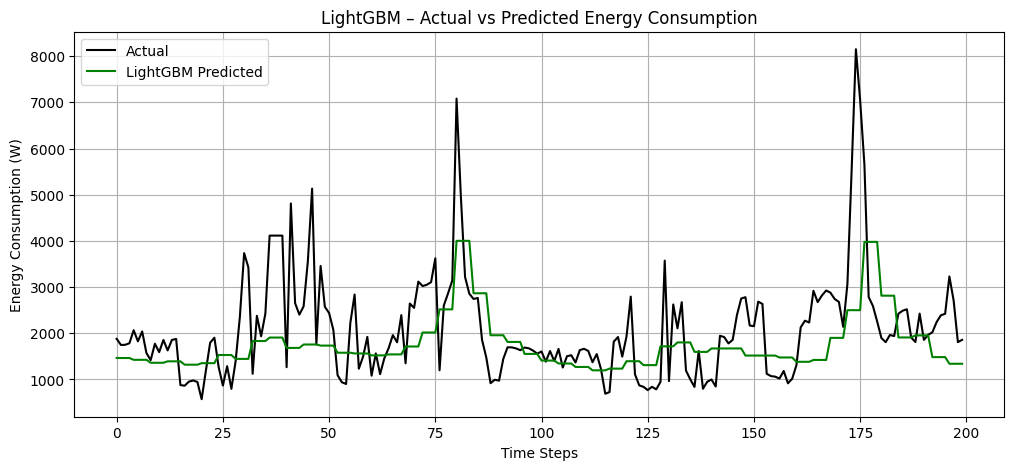

In [90]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.plot(y_test_inv[:200], label="Actual", color="black")
plt.plot(y_pred_lgb[:200], label="LightGBM Predicted", color="green")

plt.title("LightGBM – Actual vs Predicted Energy Consumption")
plt.xlabel("Time Steps")
plt.ylabel("Energy Consumption (W)")
plt.legend()
plt.grid(True)
plt.show()

***scatter plot***

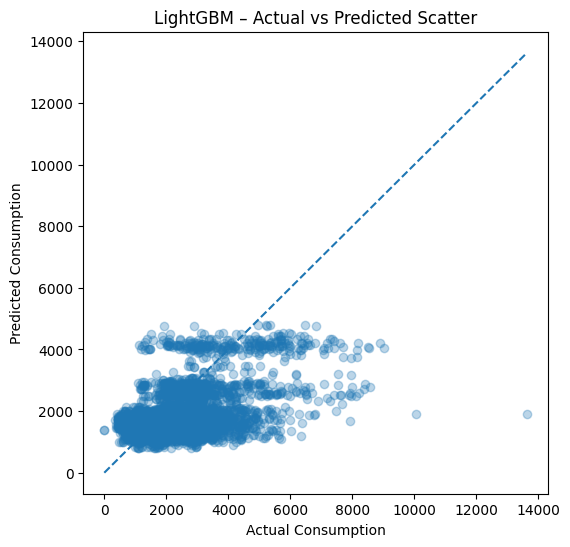

In [92]:
plt.figure(figsize=(6,6))

plt.scatter(y_test_lgbm, y_pred_lgb, alpha=0.3)
plt.plot(
    [y_test_lgbm.min(), y_test_lgbm.max()],
    [y_test_lgbm.min(), y_test_lgbm.max()],
    linestyle="--"
)

plt.title("LightGBM – Actual vs Predicted Scatter")
plt.xlabel("Actual Consumption")
plt.ylabel("Predicted Consumption")
plt.show()

***error analysis***

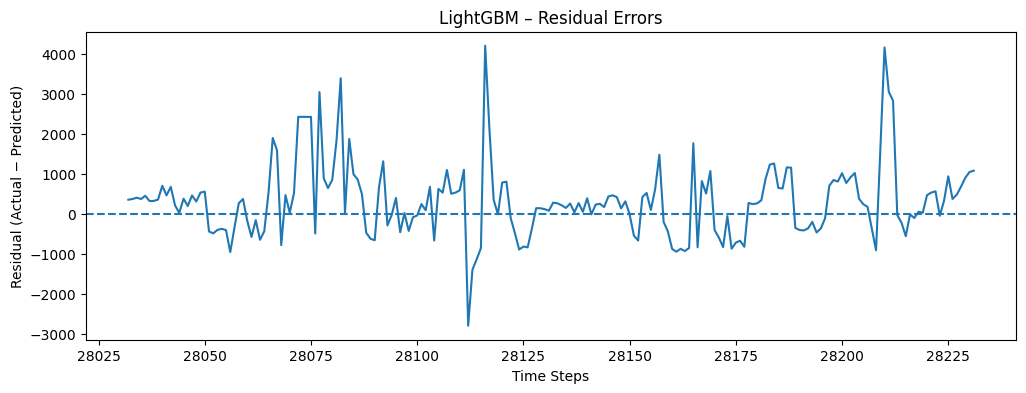

In [94]:
residuals = y_test_lgbm - y_pred_lgb

plt.figure(figsize=(12,4))
plt.plot(residuals[:200])
plt.axhline(0, linestyle="--")

plt.title("LightGBM – Residual Errors")
plt.xlabel("Time Steps")
plt.ylabel("Residual (Actual − Predicted)")
plt.show()

***feature importance***

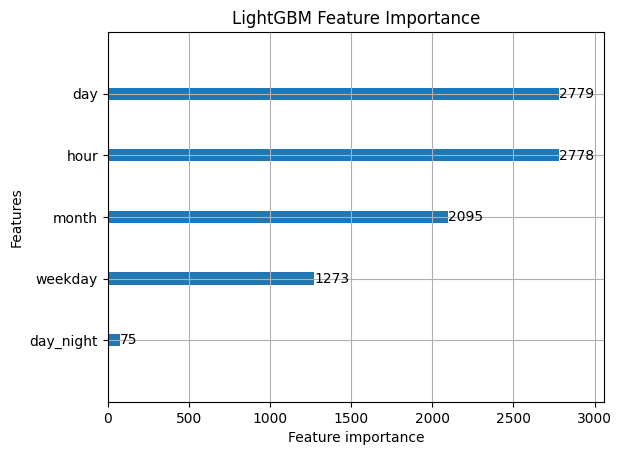

In [95]:
lgb.plot_importance(lgb_model, max_num_features=10)
plt.title("LightGBM Feature Importance")
plt.show()


saving

In [77]:
joblib.dump(lgb_model, "lightgbm.pkl")

['lightgbm.pkl']

#LSTM + GRU MODEL

targeet

In [41]:
target = 'Consumption (W)'


input features

In [42]:
features = [
    'Production (W)',
    'From Grid (W)',
    'From Solar (W)',
    'hour',
    'day',
    'month',
    'weekday',
    'day_night',
    'tariff'
]


Handle missing values

In [43]:
df[features + [target]] = df[features + [target]].fillna(method='ffill')


/tmp/ipython-input-1487500195.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[features + [target]] = df[features + [target]].fillna(method='ffill')


Feature scaling(MinMaxScaler)

In [44]:
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(df[features])
y_scaled = scaler_y.fit_transform(df[[target]])


Create time sequences

***define time steps***

In [45]:
TIME_STEPS = 24   # 24 hours


***function to create sequences***

In [46]:
import numpy as np

def create_sequences(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)


***applying(eache prediction uses previous 24 hours of energy behaviour***

In [47]:
X_seq, y_seq = create_sequences(X_scaled, y_scaled, TIME_STEPS)


Tran-test split

In [49]:
split = int(0.8 * len(X_seq))

X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]


Model building(LSTM)

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [51]:
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dense(1)
])

lstm_model.compile(
    optimizer='adam',
    loss='mse'
)

lstm_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,393 (122.63 KB)

 Trainable params: 31,393 (122.63 KB)

 Non-trainable params: 0 (0.00 B)

train lstm model

In [52]:
history_lstm = lstm_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


Epoch 1/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - loss: 0.0073 - val_loss: 0.0035
Epoch 2/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.0041 - val_loss: 0.0027
Epoch 3/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.0033 - val_loss: 0.0026
Epoch 4/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 5/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 6/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 7/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 0.0030 - val_loss: 0.0024
Epoch 8/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 9/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 10/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 11/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 12/20
788/788 ━━━━━━━━━━

predict

In [54]:
y_pred_lstm = lstm_model.predict(X_test)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


inverse scaling

In [55]:
y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_lstm_inv = scaler_y.inverse_transform(y_pred_lstm)


metrics

In [56]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

lstm_mae = mean_absolute_error(y_test_inv, y_pred_lstm_inv)
lstm_rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_lstm_inv))
lstm_r2 = r2_score(y_test_inv, y_pred_lstm_inv)

print("LSTM MAE:", lstm_mae)
print("LSTM RMSE:", lstm_rmse)
print("LSTM R2:", lstm_r2)

LSTM MAE: 524.8525558214279
LSTM RMSE: 803.9605926832007
LSTM R2: 0.5302031868394937


#visualization

Line plot(Time series)

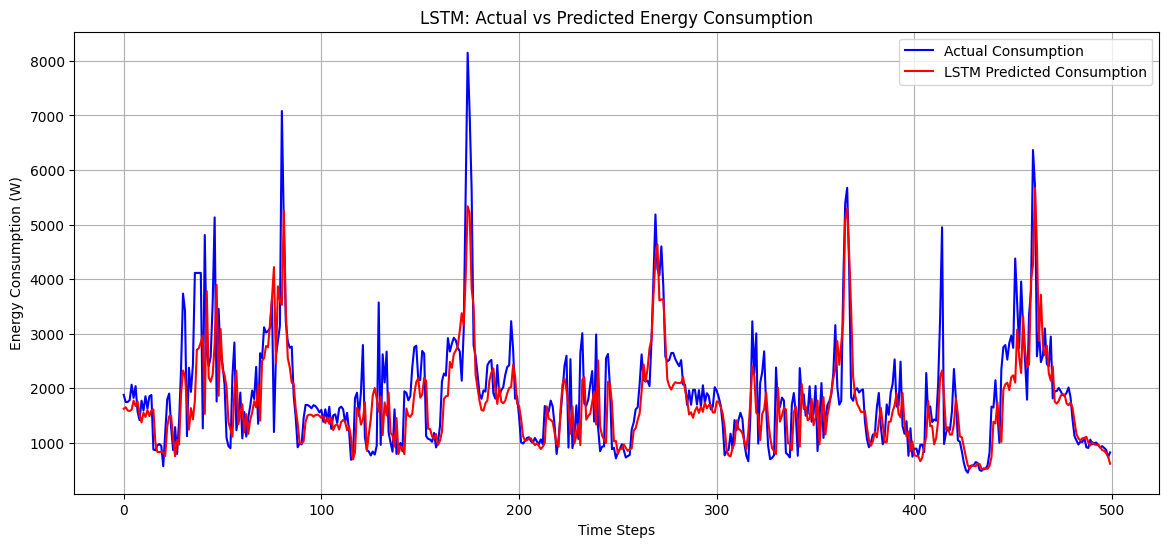

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(y_test_inv[:500], label='Actual Consumption', color='blue')
plt.plot(y_pred_lstm_inv[:500], label='LSTM Predicted Consumption', color='red')
plt.title('LSTM: Actual vs Predicted Energy Consumption')
plt.xlabel('Time Steps')
plt.ylabel('Energy Consumption (W)')
plt.legend()
plt.grid(True)
plt.show()


Scatter plot

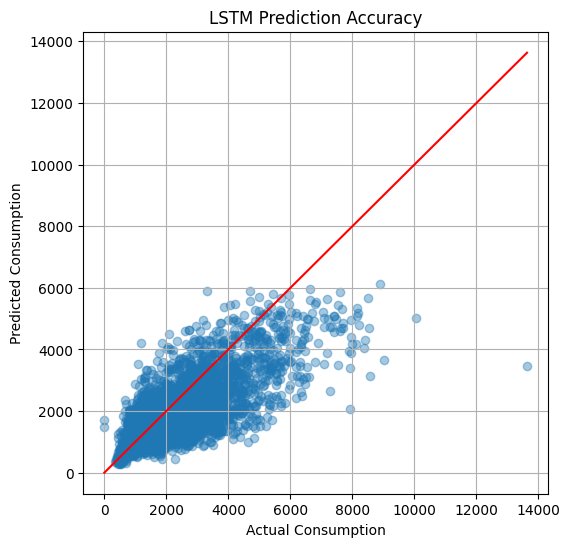

In [58]:
plt.figure(figsize=(6,6))
plt.scatter(y_test_inv, y_pred_lstm_inv, alpha=0.4)
plt.plot([y_test_inv.min(), y_test_inv.max()],
         [y_test_inv.min(), y_test_inv.max()],
         color='red')
plt.xlabel('Actual Consumption')
plt.ylabel('Predicted Consumption')
plt.title('LSTM Prediction Accuracy')
plt.grid(True)
plt.show()


training vs validation loss

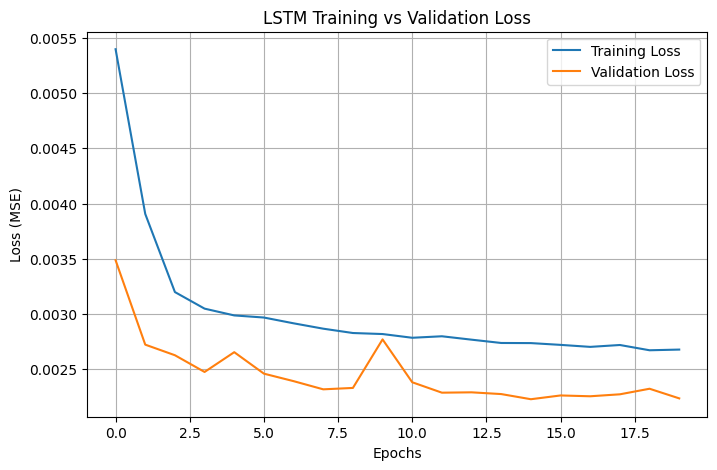

In [59]:
plt.figure(figsize=(8,5))
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()


#GRU MODEL

In [61]:
from tensorflow.keras.layers import GRU

In [62]:
gru_model = Sequential([
    GRU(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    GRU(32),
    Dense(1)
])

gru_model.compile(optimizer='adam', loss='mse')


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [63]:
history_gru = gru_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


Epoch 1/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - loss: 0.0076 - val_loss: 0.0027
Epoch 2/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 3/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.0032 - val_loss: 0.0027
Epoch 4/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 5/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 6/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 7/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 8/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 9/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 10/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 11/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 12/20
788/788 ━━━━━━━━━━

evaluate gru

In [64]:
y_pred_gru = gru_model.predict(X_test)

y_pred_gru_inv = scaler_y.inverse_transform(y_pred_gru)

gru_mae = mean_absolute_error(y_test_inv, y_pred_gru_inv)
gru_rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_gru_inv))
gru_r2 = r2_score(y_test_inv, y_pred_gru_inv)

print("GRU MAE:", gru_mae)
print("GRU RMSE:", gru_rmse)
print("GRU R2:", gru_r2)

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
GRU MAE: 499.189867510697
GRU RMSE: 762.1183658982275
GRU R2: 0.5778319152210638


#visualisation

actual vs predicted gru

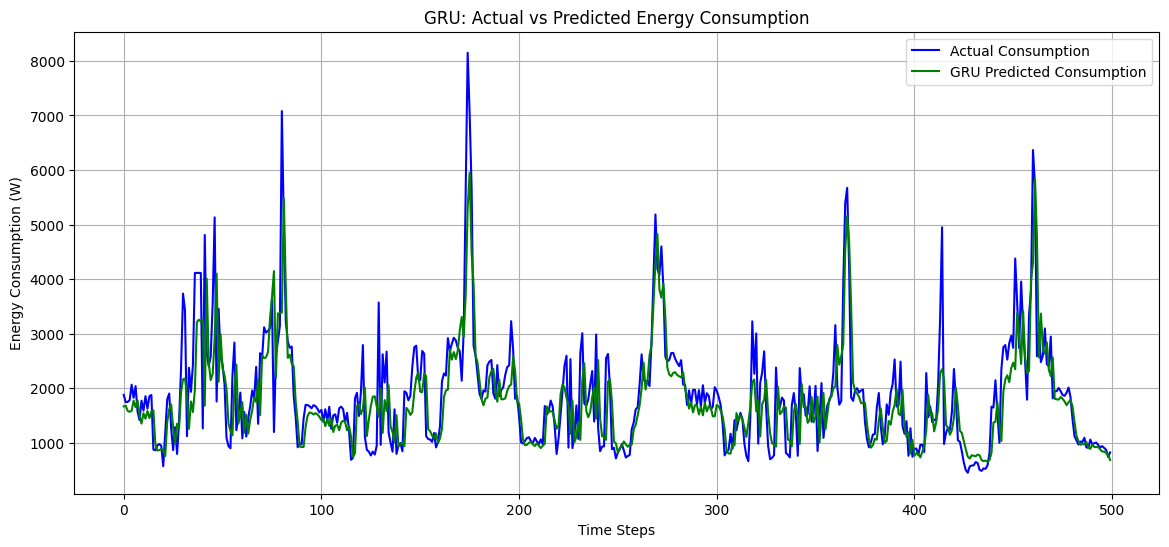

In [65]:
plt.figure(figsize=(14,6))
plt.plot(y_test_inv[:500], label='Actual Consumption', color='blue')
plt.plot(y_pred_gru_inv[:500], label='GRU Predicted Consumption', color='green')
plt.title('GRU: Actual vs Predicted Energy Consumption')
plt.xlabel('Time Steps')
plt.ylabel('Energy Consumption (W)')
plt.legend()
plt.grid(True)
plt.show()


scatter plot

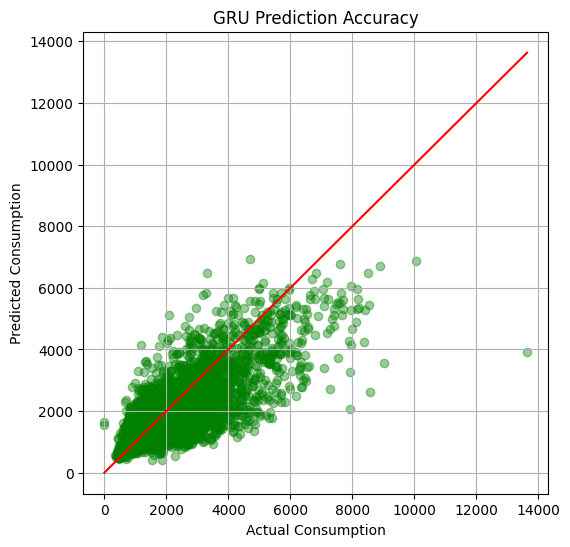

In [66]:
plt.figure(figsize=(6,6))
plt.scatter(y_test_inv, y_pred_gru_inv, alpha=0.4, color='green')
plt.plot([y_test_inv.min(), y_test_inv.max()],
         [y_test_inv.min(), y_test_inv.max()],
         color='red')
plt.xlabel('Actual Consumption')
plt.ylabel('Predicted Consumption')
plt.title('GRU Prediction Accuracy')
plt.grid(True)
plt.show()


gru loss curve

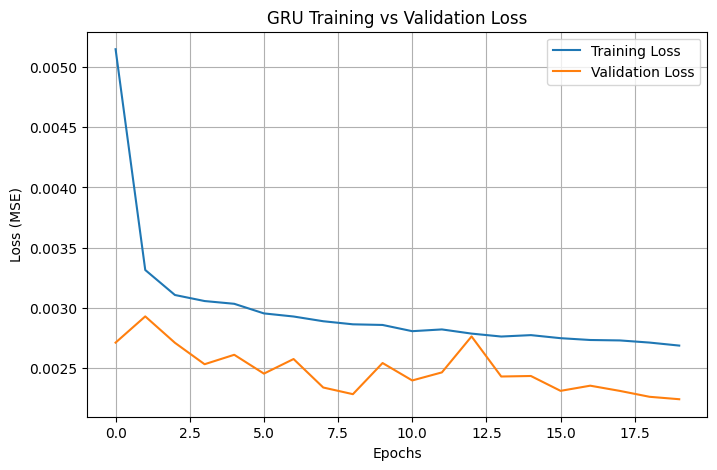

In [67]:
plt.figure(figsize=(8,5))
plt.plot(history_gru.history['loss'], label='Training Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.title('GRU Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()


***model comparison bar chart***

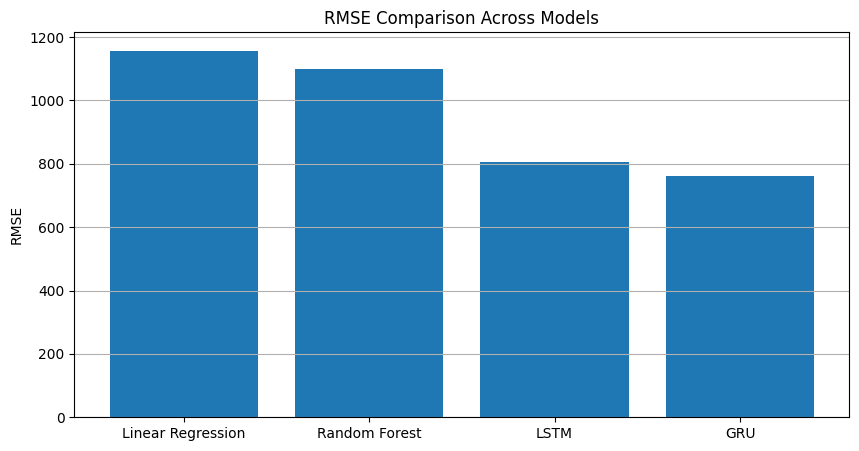

In [68]:
models = ['Linear Regression', 'Random Forest', 'LSTM', 'GRU']
mae_scores = [794, 787, lstm_mae, gru_mae]
rmse_scores = [1157, 1098, lstm_rmse, gru_rmse]

plt.figure(figsize=(10,5))
plt.bar(models, rmse_scores)
plt.title('RMSE Comparison Across Models')
plt.ylabel('RMSE')
plt.grid(axis='y')
plt.show()


In [69]:
lstm_model.save('lstm_consumption_model.h5')
gru_model.save('gru_consumption_model.h5')


***comparison table***

In [83]:
import pandas as pd

results = pd.DataFrame({
    "Model": [
        "Linear Regression",
        "Random Forest",
        "LightGBM",
        "LSTM",
        "GRU"
    ],
    "MAE": [
        mae_lr,
        mae_rf,
        lgb_mae,
        lstm_mae,
        gru_mae
    ],
    "RMSE": [
        rmse_lr,
        rmse_rf,
        lgb_rmse,
        lstm_rmse,
        gru_rmse
    ],
    "R2 Score": [
        r2_lr,
        r2_rf,
        lgb_r2,
        lstm_r2,
        gru_r2
    ]
})

results


,Model,MAE,RMSE,R2 Score
0,Linear Regression,794.404333,1157.388999,0.025822
1,Random Forest,786.991320,1097.982283,0.123261
2,LightGBM,746.764038,1063.389863,0.177635
3,LSTM,524.852556,803.960593,0.530203
4,GRU,499.189868,762.118366,0.577832


from matplotlib import pyplot as plt
results['MAE'].plot(kind='hist', bins=20, title='MAE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results['RMSE'].plot(kind='hist', bins=20, title='RMSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results['R2 Score'].plot(kind='hist', bins=20, title='R2 Score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
results.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results.plot(kind='scatter', x='MAE', y='RMSE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results.plot(kind='scatter', x='RMSE', y='R2 Score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['R2 Score']
  ys = series['MAE']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results.sort_values('R2 Score', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('R2 Score')
_ = plt.ylabel('MAE')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['R2 Score']
  ys = series['RMSE']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results.sort_values('R2 Score', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('R2 Score')
_ = plt.ylabel('RMSE')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['R2 Score']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'R2 Score'}, axis=1)
              .sort_values('R2 Score', ascending=True))
  xs = counted['R2 Score']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results.sort_values('R2 Score', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('R2 Score')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
results['MAE'].plot(kind='line', figsize=(8, 4), title='MAE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results['RMSE'].plot(kind='line', figsize=(8, 4), title='RMSE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results['R2 Score'].plot(kind='line', figsize=(8, 4), title='R2 Score')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results, x='MAE', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results, x='RMSE', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results, x='R2 Score', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [71]:
results.to_csv("model_comparison_results.csv", index=False)


***comparison curve***

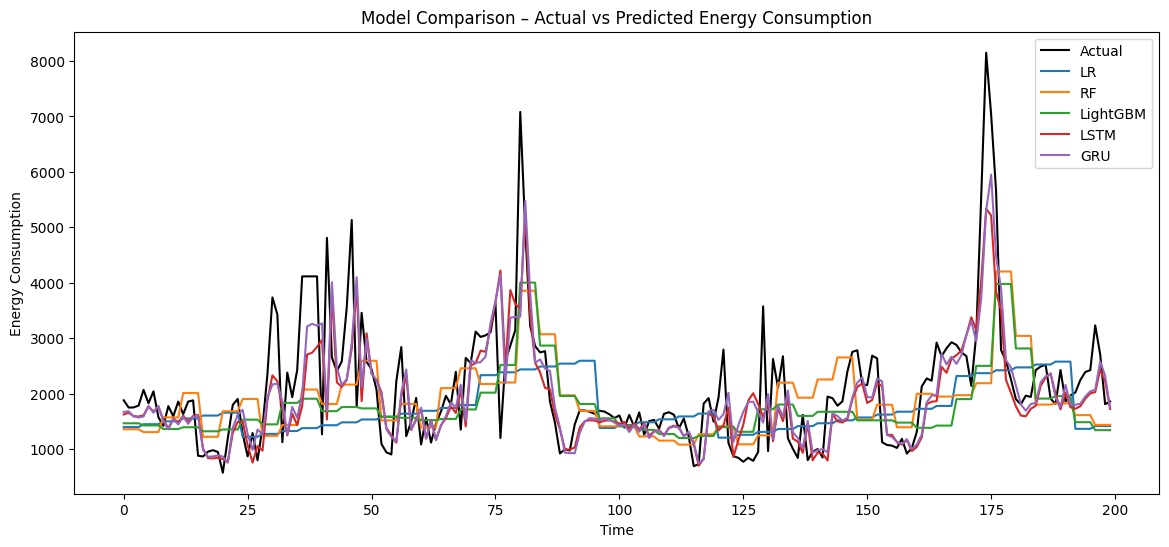

In [86]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

plt.plot(y_test_inv[:200], label="Actual", color="black")

# Use X_test_lgbm for LR and RF as they were trained on 2D data similar to LGBM
plt.plot(lr.predict(X_test_lgbm)[:200], label="LR")
plt.plot(rf.predict(X_test_lgbm)[:200], label="RF")
plt.plot(y_pred_lgb[:200], label="LightGBM")
plt.plot(y_pred_lstm_inv[:200], label="LSTM")
plt.plot(y_pred_gru_inv[:200], label="GRU")

plt.title("Model Comparison – Actual vs Predicted Energy Consumption")
plt.xlabel("Time")
plt.ylabel("Energy Consumption")
plt.legend()
plt.show()

In [87]:
plt.savefig("model_comparison_curve.png", dpi=300, bbox_inches='tight')


<Figure size 640x480 with 0 Axes>